In [1]:
import numpy as np

# import qutip as qt
import torch
from torch.utils.data import Dataset, DataLoader
import joblib

import torch.nn as nn
import matplotlib.pyplot as plt

from torch import tensor

from qbism import sic_povm

In [8]:
a = torch.randn(2, 2) + 1j * torch.randn(2, 2)
print(a)

a.flatten()

tensor([[0.8953+2.0181j, 0.5864+0.5808j],
        [1.0162-0.2163j, 0.8216+0.5308j]])


tensor([0.8953+2.0181j, 0.5864+0.5808j, 1.0162-0.2163j, 0.8216+0.5308j])

In [86]:
def dag(A):
    return torch.conj(A.T)


def sprepost(A, B):
    Bt = B.T.contiguous()
    return torch.kron(A.contiguous(), Bt)


def spre(A):
    return sprepost(A, torch.eye(A.shape[0]))


def spost(A):
    return sprepost(torch.eye(A.shape[0]), A)


# def vec(A):
#     return A.flatten()
def vec(A):
    return A.flatten()

In [46]:
d = 2

povm_arr = tensor(np.array(sic_povm(d)) * d)

In [62]:
torch.vmap(vec)(povm_arr).T

tensor([[ 0.7887+0.0000j,  0.7887+0.0000j,  0.2113+0.0000j,  0.2113+0.0000j],
        [ 0.2887+0.2887j, -0.2887-0.2887j,  0.2887-0.2887j, -0.2887+0.2887j],
        [ 0.2887-0.2887j, -0.2887+0.2887j,  0.2887+0.2887j, -0.2887-0.2887j],
        [ 0.2113+0.0000j,  0.2113+0.0000j,  0.7887+0.0000j,  0.7887+0.0000j]],
       dtype=torch.complex128)

In [65]:
torch.eye(2)

tensor([[1., 0.],
        [0., 1.]])

In [66]:
torch.stack([vec(torch.eye(2))] * d**2)

tensor([[1., 0., 0., 1.],
        [1., 0., 0., 1.],
        [1., 0., 0., 1.],
        [1., 0., 0., 1.]])

In [67]:
K = (d + 1) * torch.vmap(vec)(povm_arr).T - torch.stack(
    [vec(torch.eye(2))] * d**2
).T

In [69]:
K_inv = (torch.stack([dag(vec(pi)) for pi in list(povm_arr)])) / d

In [70]:
K

tensor([[ 1.3660+0.0000j,  1.3660+0.0000j, -0.3660+0.0000j, -0.3660+0.0000j],
        [ 0.8660+0.8660j, -0.8660-0.8660j,  0.8660-0.8660j, -0.8660+0.8660j],
        [ 0.8660-0.8660j, -0.8660+0.8660j,  0.8660+0.8660j, -0.8660-0.8660j],
        [-0.3660+0.0000j, -0.3660+0.0000j,  1.3660+0.0000j,  1.3660+0.0000j]],
       dtype=torch.complex128)

In [71]:
K_inv

tensor([[ 0.3943-0.0000j,  0.1443-0.1443j,  0.1443+0.1443j,  0.1057-0.0000j],
        [ 0.3943-0.0000j, -0.1443+0.1443j, -0.1443-0.1443j,  0.1057-0.0000j],
        [ 0.1057-0.0000j,  0.1443+0.1443j,  0.1443-0.1443j,  0.3943-0.0000j],
        [ 0.1057-0.0000j, -0.1443-0.1443j, -0.1443+0.1443j,  0.3943-0.0000j]],
       dtype=torch.complex128)

In [73]:
def psic_to_rho(p_arr, povm_arr, d):
    K = (d + 1) * povm_arr - torch.eye(d)
    return torch.einsum("ijk,i", K, p_arr)


def rho_to_psic(rho, povm_arr, d):
    return (
        torch.einsum("ill", torch.einsum("ijk, kl -> ijl", povm_arr, rho)) / d
    )

In [89]:
# Lindbladian generator.

# it accepts gamma, S

ketbra11 = tensor([[1, 0], [0, 0]])

s_plus = tensor([[0, 1], [0, 0]])

s_minus = s_plus.T

unitary_part = -1j / 2 * (spre(ketbra11) - spost(ketbra11))

dissipator = sprepost(s_minus, dag(s_minus)) - 0.5 * (
    spre(dag(s_minus) @ s_minus) + spost(dag(s_minus) @ s_minus)
)


def _make_L(S, gamma):
    return S * unitary_part + gamma * dissipator

In [92]:
_make_L(0, 1)

tensor([[-1.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j, -0.5000+0.j,  0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j, -0.5000+0.j,  0.0000+0.j],
        [ 1.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j]])

In [82]:
s_plus

tensor([[0, 1],
        [0, 0]])

In [93]:
gamma_0 = 20
lamda = 0.8

In [88]:
dissipator

tensor([[-1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.5000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.5000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000]])

In [103]:
raw_data = tensor(
    joblib.load("raw_data.job").real.swapaxes(1, 2), dtype=torch.complex128
)

In [104]:
raw_data[25].shape

torch.Size([4, 5000])

In [106]:
psic_to_rho(raw_data[25, :, 0], povm_arr, d=2)

tensor([[0.4178+0.0000j, 0.4473-0.1528j],
        [0.4473+0.1528j, 0.5822+0.0000j]], dtype=torch.complex128)

In [127]:
np.sqrt(1 - 2 * gamma_0 / lamda + 1j * 0)

7j

In [129]:
def gamma(t, gamma_0, lamda):
    delta = np.sqrt(1 - 2 * gamma_0 / lamda + 1j * 0)
    return (
        2
        * gamma_0
        * (
            (np.sinh(lamda * t * delta / 2))
            / (
                delta * np.cosh(lamda * t * delta / 2)
                + np.sinh(delta * t * lamda / 2)
            )
        )
    )

/home/antonio/miniconda3/envs/torch/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/antonio/miniconda3/envs/torch/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(10.0, -10.0)

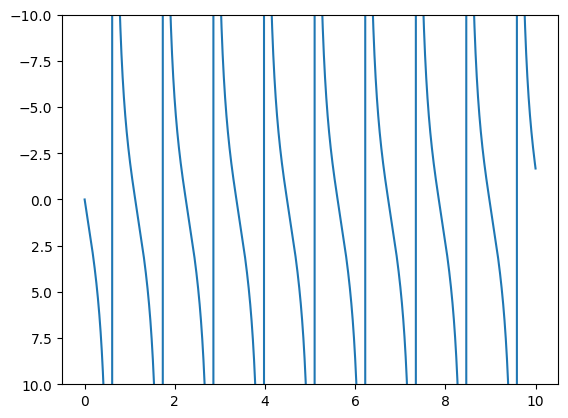

In [132]:
times = np.linspace(0, 10, 5000)

plt.plot(times, gamma(times, gamma_0, lamda))
plt.ylim(10, -10)

In [115]:
evolved_rho = torch.vmap(
    lambda povm_step: psic_to_rho(povm_step, povm_arr, d=2)
)(raw_data[25].T)
print(evolved_rho.shape)

torch.Size([5000, 2, 2])


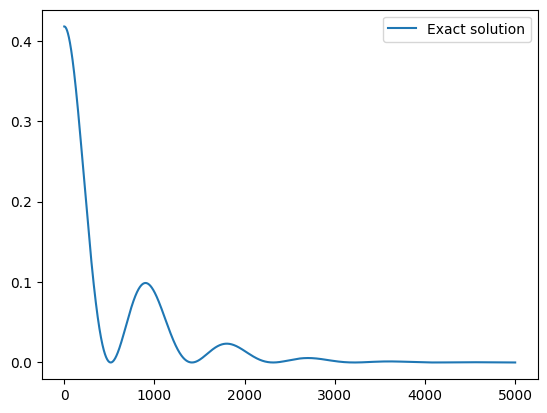

In [124]:
plt.plot(evolved_rho[:, 0, 0].real, label="Exact solution")
plt.legend()
plt.show()

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
class CNNDensityMatrix(nn.Module):
    def __init__(
        self, no_channels, no_filters, kernel_window, timeseries_length
    ):
        super(CNNDensityMatrix, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=no_channels,
            out_channels=no_filters,
            kernel_size=kernel_window,
        )
        # len_output_of_conv1d = timeseries_length - kernel_window + 1
        # self.fc1 = nn.Linear(len_output_of_conv1d * no_filters, no_channels)
        self.fc1 = nn.Linear(no_filters, no_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.fc1(x.permute(0, 2, 1)).permute(0, 2, 1)
        return x


class DensityMatrixDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (self.X[idx], self.y[idx])
        return sample

In [7]:
N = raw_data.shape[0]
C = raw_data.shape[1]
L = raw_data.shape[2]

no_filters = 16

kernel_window = 4


model = CNNDensityMatrix(
    no_channels=C,
    no_filters=no_filters,
    kernel_window=kernel_window,
    timeseries_length=L,
)

# model = model.to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print(model)

CNNDensityMatrix(
  (conv1): Conv1d(4, 16, kernel_size=(4,), stride=(1,))
  (fc1): Linear(in_features=16, out_features=4, bias=True)
)


In [6]:
X_raw = raw_data
y_raw = raw_data[:, :, kernel_window - 1 :]

dataset = DensityMatrixDataset(X_raw, y_raw)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [10]:
model(tensor(X_raw)).shape
# We need to keep this structure in the end.
# We are gonna make the output of the linear to be 1000, 2, 4997
# Then, we take these two scalas, gamma and S, to evolve the last timestep

torch.Size([1000, 4, 4997])